In [1]:
import torch
import numpy as np
import skimage
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls drive/'My Drive'

 carseg_data	    data_utils.py	  plotting.py		  submission.csv   文档
'Colab Notebooks'   images		 'Project of DL'	  test.csv
 data.pickle	    leaf-classification   sample_submission.csv   train.csv


In [4]:
date_path = 'drive/My Drive/carseg_data/'
array_path = date_path + 'arrays/'

In [5]:
array_names = glob.glob(array_path + '*.npy')
array_names.sort()
print(f"Number of arrays: {len(array_names)}")
black_arrays = []
orange_arrays = []
photo_arrays = []

for array in array_names:
    if 'black' in array:
        black_arrays.append(np.load(array))
    if 'orange' in array:
        orange_arrays.append(np.load(array))
    if 'photo' in array:
        photo_arrays.append(np.load(array))

black_arrays = np.array(black_arrays)
orange_arrays = np.array(orange_arrays)
photo_arrays = np.array(photo_arrays)



print(f"Number of black arrays: {len(black_arrays)}")
print(black_arrays.shape)
print(f"Number of orange arrays: {len(orange_arrays)}")
print(orange_arrays.shape)
print(f"Number of photo arrays: {len(photo_arrays)}")
print(photo_arrays.shape)
print(f"Total: {len(black_arrays) + len(orange_arrays) + len(photo_arrays)}")

Number of arrays: 3004
Number of black arrays: 834
(834, 256, 256, 4)
Number of orange arrays: 2001
(2001, 256, 256, 4)
Number of photo arrays: 169
(169, 256, 256, 4)
Total: 3004


# **Data process**

input size (n,256,256,4) \\
I think if it's good, we can save the dateset so that we don't need to process the date each time.

In [6]:
from sklearn.preprocessing import OneHotEncoder


In [7]:
categories = [
    [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
 ]
encoder = OneHotEncoder(categories=categories, sparse_output=False)
def onehot(data, n):
    data_flat = data.ravel()
    onehot_encoded = encoder.fit_transform(data_flat.reshape(-1, 1))
    onehot_encoded = onehot_encoded.reshape(256, 256, -1)
    return onehot_encoded


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        image = sample[:,:,:3]  #rgd image
        label = sample[:,:,3]  #label image

        # change date type form numpy to tensor
        if transform is not None:
            image = transform(image)

        label = onehot(label, 10) # (n,256,256,10)
        label = label.transpose(2,0,1)#(n,10, 256,256)
        label = torch.FloatTensor(label)

        return image, label





In [8]:
carpart = MyDataset(black_arrays, transform)
#torch.save(carpart, 'carpart_dataset.pth')  #save the dataset
train_size = int(0.9 * len(carpart))   #90% for train
test_size = len(carpart) - train_size #10% for test
train_dataset, test_dataset = random_split(carpart, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=True, num_workers=2)

In [9]:
'''
#test if the onehot function works well
onehottest = (black_arrays[703,:,:,3] / 10).astype(np.int32)
print(onehottest.max())
print(onehottest)
print(black_arrays[0,:,:,3].dtype)


print(onehot_encoded.shape)
print(onehot_encoded[:,:,0]) #(1, 10, 256, 256)
onehot_encoded = (np.argmax(onehot_encoded, axis=2) * 10).astype(np.uint8)
print(onehot_encoded.shape)  #(1,256, 256)

plt.subplot(1, 2, 1)
plt.imshow(label2colar(black_arrays[703,:,:,3]))
plt.subplot(1, 2, 2)
plt.imshow(label2colar(onehot_encoded))
'''

'\n#test if the onehot function works well\nonehottest = (black_arrays[703,:,:,3] / 10).astype(np.int32)\nprint(onehottest.max())\nprint(onehottest)\nprint(black_arrays[0,:,:,3].dtype)\n\n\nprint(onehot_encoded.shape)\nprint(onehot_encoded[:,:,0]) #(1, 10, 256, 256)\nonehot_encoded = (np.argmax(onehot_encoded, axis=2) * 10).astype(np.uint8)\nprint(onehot_encoded.shape)  #(1,256, 256)\n\nplt.subplot(1, 2, 1)\nplt.imshow(label2colar(black_arrays[703,:,:,3]))\nplt.subplot(1, 2, 2)\nplt.imshow(label2colar(onehot_encoded))\n'

# The basic architechture of model

In [10]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [11]:
#Architect of U_net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1,bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features = [64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Down part of U_net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #Up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                    )# 28*1024 -> 56 * 512
            )
            self.ups.append(DoubleConv(feature*2, feature))
        #bottle
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)  #1024
        #final FF
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            #checking
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size= skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim = 1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [12]:
def test():
    x = torch.randn((3, 3, 256, 256))# n = 3, in_channel = 3, h = w =256
    model = UNET(in_channels = 3, out_channels = 10)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    #shape of input and output is same


test()

torch.Size([3, 10, 256, 256])
torch.Size([3, 3, 256, 256])


# Train

In [13]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange

In [14]:

def train(epo_num=50, show_vgg_params=False):


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    model = UNET(in_channels = 3, out_channels = 10)#input is rgb output is 10 classes
    model = model.to(device)
    criterion = nn.BCELoss().to(device) #loss
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.7) #optimizer

    all_train_iter_loss = []
    all_test_iter_loss = []

    # start timing
    prev_time = datetime.now()
    for epo in trange(epo_num):

        train_loss = 0
        model.train()
        for index, (car, car_msk) in enumerate(train_dataloader):
            # car.shape is torch.Size([12, 3, 256, 256])
            # car_msk.shape is torch.Size([12, 10, 256, 256])

            car = car.to(device)
            car_msk = car_msk.to(device)

            optimizer.zero_grad()
            output = model(car)
            output = torch.sigmoid(output) # output.shape is torch.Size([12, 10, 256, 256])
            # print(output)
            # print(car_msk)
            loss = criterion(output, car_msk)
            loss.backward()
            iter_loss = loss.item()
            all_train_iter_loss.append(iter_loss)
            train_loss += iter_loss
            optimizer.step()

            output_np = output.cpu().detach().numpy().copy() # output_np.shape = (12, 10, 256, 256)
            output_np = (np.argmax(output_np, axis=1)*10).astype(np.uint8)
            car_msk_np = car_msk.cpu().detach().numpy().copy() # car_msk_np.shape = (12, 10, 256, 256)
            car_msk_np = (np.argmax(car_msk_np, axis=1)*10).astype(np.uint8)

        test_loss = 0
        model.eval()
        #I think we could don't have a test during the train
        with torch.no_grad():
            for index, (car, car_msk) in enumerate(test_dataloader):

                car = car.to(device)
                car_msk = car_msk.to(device)

                optimizer.zero_grad()
                output = model(car)
                output = torch.sigmoid(output) # output.shape is torch.Size([12, 10, 256, 256])
                loss = criterion(output, car_msk)
                iter_loss = loss.item()
                all_test_iter_loss.append(iter_loss)
                test_loss += iter_loss

                output_np = output.cpu().detach().numpy().copy() # output_np.shape = (12, 10, 256, 256)
                output_np = (np.argmax(output_np, axis=1)*10).astype(np.uint8)
                car_msk_np = car_msk.cpu().detach().numpy().copy() # car_msk_np.shape = (12, 10, 256, 256)
                car_msk_np = (np.argmax(car_msk_np, axis=1)*10).astype(np.uint8)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        prev_time = cur_time

        print('epoch:', epo, '/', epo_num)
        print('epoch train loss = %f, epoch test loss = %f, %s'
                %(train_loss/len(train_dataloader), test_loss/len(test_dataloader), time_str))

        #save model
        #if np.mod(epo, 5) == 0:
            #torch.save(model, 'checkpoints/model_{}.pt'.format(epo))
            #print('saveing checkpoints/model_{}.pt'.format(epo))
    return model


if __name__ == "__main__":
    model = train(epo_num=50)

  2%|▏         | 1/50 [00:57<46:54, 57.44s/it]

epoch: 0 / 50
epoch train loss = 0.568751, epoch test loss = 0.488686, Time 00:00:57


  4%|▍         | 2/50 [01:50<43:54, 54.88s/it]

epoch: 1 / 50
epoch train loss = 0.359016, epoch test loss = 0.303978, Time 00:00:53


  6%|▌         | 3/50 [02:43<42:16, 53.97s/it]

epoch: 2 / 50
epoch train loss = 0.230050, epoch test loss = 0.194155, Time 00:00:52


  8%|▊         | 4/50 [03:36<41:12, 53.74s/it]

epoch: 3 / 50
epoch train loss = 0.163376, epoch test loss = 0.141431, Time 00:00:53


 10%|█         | 5/50 [04:29<39:58, 53.30s/it]

epoch: 4 / 50
epoch train loss = 0.126786, epoch test loss = 0.113521, Time 00:00:52


 12%|█▏        | 6/50 [05:21<38:55, 53.07s/it]

epoch: 5 / 50
epoch train loss = 0.104862, epoch test loss = 0.095621, Time 00:00:52


 14%|█▍        | 7/50 [06:14<37:51, 52.82s/it]

epoch: 6 / 50
epoch train loss = 0.090927, epoch test loss = 0.080965, Time 00:00:52


 16%|█▌        | 8/50 [07:07<36:58, 52.83s/it]

epoch: 7 / 50
epoch train loss = 0.081076, epoch test loss = 0.075058, Time 00:00:52


 18%|█▊        | 9/50 [07:59<36:03, 52.76s/it]

epoch: 8 / 50
epoch train loss = 0.073895, epoch test loss = 0.067837, Time 00:00:52


 20%|██        | 10/50 [08:52<35:07, 52.68s/it]

epoch: 9 / 50
epoch train loss = 0.068371, epoch test loss = 0.062113, Time 00:00:52


 22%|██▏       | 11/50 [09:44<34:14, 52.68s/it]

epoch: 10 / 50
epoch train loss = 0.064180, epoch test loss = 0.058567, Time 00:00:52


 24%|██▍       | 12/50 [10:37<33:22, 52.69s/it]

epoch: 11 / 50
epoch train loss = 0.060553, epoch test loss = 0.055341, Time 00:00:52


 26%|██▌       | 13/50 [11:30<32:27, 52.64s/it]

epoch: 12 / 50
epoch train loss = 0.057177, epoch test loss = 0.053155, Time 00:00:52


 28%|██▊       | 14/50 [12:22<31:29, 52.47s/it]

epoch: 13 / 50
epoch train loss = 0.054738, epoch test loss = 0.050804, Time 00:00:52


 30%|███       | 15/50 [13:14<30:31, 52.33s/it]

epoch: 14 / 50
epoch train loss = 0.052595, epoch test loss = 0.049151, Time 00:00:51


 32%|███▏      | 16/50 [14:06<29:40, 52.37s/it]

epoch: 15 / 50
epoch train loss = 0.050945, epoch test loss = 0.047236, Time 00:00:52


 34%|███▍      | 17/50 [14:58<28:42, 52.20s/it]

epoch: 16 / 50
epoch train loss = 0.049111, epoch test loss = 0.045648, Time 00:00:51


 36%|███▌      | 18/50 [15:50<27:49, 52.17s/it]

epoch: 17 / 50
epoch train loss = 0.047753, epoch test loss = 0.044232, Time 00:00:52


 38%|███▊      | 19/50 [16:42<26:56, 52.16s/it]

epoch: 18 / 50
epoch train loss = 0.046353, epoch test loss = 0.043457, Time 00:00:52


 40%|████      | 20/50 [17:35<26:11, 52.39s/it]

epoch: 19 / 50
epoch train loss = 0.045441, epoch test loss = 0.042098, Time 00:00:52


 42%|████▏     | 21/50 [18:28<25:19, 52.40s/it]

epoch: 20 / 50
epoch train loss = 0.044308, epoch test loss = 0.041024, Time 00:00:52


 44%|████▍     | 22/50 [19:20<24:25, 52.35s/it]

epoch: 21 / 50
epoch train loss = 0.043414, epoch test loss = 0.040225, Time 00:00:52


 46%|████▌     | 23/50 [20:12<23:32, 52.33s/it]

epoch: 22 / 50
epoch train loss = 0.042554, epoch test loss = 0.039674, Time 00:00:52


 48%|████▊     | 24/50 [21:04<22:38, 52.24s/it]

epoch: 23 / 50
epoch train loss = 0.041630, epoch test loss = 0.038807, Time 00:00:52


 50%|█████     | 25/50 [21:56<21:40, 52.02s/it]

epoch: 24 / 50
epoch train loss = 0.041021, epoch test loss = 0.037919, Time 00:00:51


 52%|█████▏    | 26/50 [22:48<20:50, 52.10s/it]

epoch: 25 / 50
epoch train loss = 0.040251, epoch test loss = 0.037461, Time 00:00:52


 54%|█████▍    | 27/50 [23:40<20:00, 52.18s/it]

epoch: 26 / 50
epoch train loss = 0.039620, epoch test loss = 0.036827, Time 00:00:52


 56%|█████▌    | 28/50 [24:33<19:10, 52.29s/it]

epoch: 27 / 50
epoch train loss = 0.038922, epoch test loss = 0.036228, Time 00:00:52


 58%|█████▊    | 29/50 [25:25<18:14, 52.13s/it]

epoch: 28 / 50
epoch train loss = 0.038445, epoch test loss = 0.035640, Time 00:00:51


 60%|██████    | 30/50 [26:17<17:21, 52.09s/it]

epoch: 29 / 50
epoch train loss = 0.037782, epoch test loss = 0.035076, Time 00:00:51


 62%|██████▏   | 31/50 [27:09<16:29, 52.08s/it]

epoch: 30 / 50
epoch train loss = 0.037250, epoch test loss = 0.034618, Time 00:00:52


 64%|██████▍   | 32/50 [28:01<15:40, 52.27s/it]

epoch: 31 / 50
epoch train loss = 0.036802, epoch test loss = 0.034545, Time 00:00:52


 66%|██████▌   | 33/50 [28:54<14:49, 52.33s/it]

epoch: 32 / 50
epoch train loss = 0.036228, epoch test loss = 0.033433, Time 00:00:52


 68%|██████▊   | 34/50 [29:46<13:55, 52.24s/it]

epoch: 33 / 50
epoch train loss = 0.035661, epoch test loss = 0.033061, Time 00:00:52


 70%|███████   | 35/50 [30:38<13:04, 52.27s/it]

epoch: 34 / 50
epoch train loss = 0.035232, epoch test loss = 0.032734, Time 00:00:52


 72%|███████▏  | 36/50 [31:30<12:11, 52.28s/it]

epoch: 35 / 50
epoch train loss = 0.034721, epoch test loss = 0.032240, Time 00:00:52


 74%|███████▍  | 37/50 [32:23<11:21, 52.46s/it]

epoch: 36 / 50
epoch train loss = 0.034444, epoch test loss = 0.031752, Time 00:00:52


 76%|███████▌  | 38/50 [33:16<10:30, 52.52s/it]

epoch: 37 / 50
epoch train loss = 0.034010, epoch test loss = 0.031397, Time 00:00:52


 78%|███████▊  | 39/50 [34:09<09:37, 52.51s/it]

epoch: 38 / 50
epoch train loss = 0.033618, epoch test loss = 0.030903, Time 00:00:52


 80%|████████  | 40/50 [35:02<08:47, 52.74s/it]

epoch: 39 / 50
epoch train loss = 0.033198, epoch test loss = 0.030752, Time 00:00:53


 82%|████████▏ | 41/50 [35:54<07:53, 52.66s/it]

epoch: 40 / 50
epoch train loss = 0.032795, epoch test loss = 0.030362, Time 00:00:52


 84%|████████▍ | 42/50 [36:46<07:00, 52.51s/it]

epoch: 41 / 50
epoch train loss = 0.032532, epoch test loss = 0.030211, Time 00:00:52


 86%|████████▌ | 43/50 [37:39<06:07, 52.54s/it]

epoch: 42 / 50
epoch train loss = 0.032276, epoch test loss = 0.029490, Time 00:00:52


 88%|████████▊ | 44/50 [38:32<05:15, 52.64s/it]

epoch: 43 / 50
epoch train loss = 0.031795, epoch test loss = 0.029281, Time 00:00:52


 90%|█████████ | 45/50 [39:25<04:24, 52.85s/it]

epoch: 44 / 50
epoch train loss = 0.031511, epoch test loss = 0.029069, Time 00:00:53


 92%|█████████▏| 46/50 [40:18<03:31, 52.76s/it]

epoch: 45 / 50
epoch train loss = 0.031246, epoch test loss = 0.028821, Time 00:00:52


 94%|█████████▍| 47/50 [41:10<02:37, 52.52s/it]

epoch: 46 / 50
epoch train loss = 0.031053, epoch test loss = 0.028532, Time 00:00:51


 96%|█████████▌| 48/50 [42:02<01:44, 52.46s/it]

epoch: 47 / 50
epoch train loss = 0.030734, epoch test loss = 0.028193, Time 00:00:52


 98%|█████████▊| 49/50 [42:54<00:52, 52.35s/it]

epoch: 48 / 50
epoch train loss = 0.030270, epoch test loss = 0.028126, Time 00:00:52


100%|██████████| 50/50 [43:46<00:00, 52.53s/it]

epoch: 49 / 50
epoch train loss = 0.030188, epoch test loss = 0.027869, Time 00:00:52


Test

In [22]:
import numpy as np
#Use skimage package to deal image
from skimage import io
from skimage.io import imread
import matplotlib.pyplot as plt

from data_process import label2colar,result2image,resize_image_to_256,resize_result_to_original

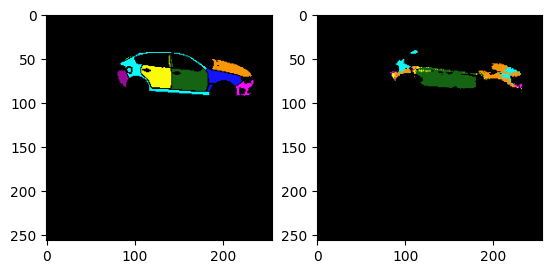

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if __name__ =='__main__':
    imgA = imread('drive/My Drive/carseg_data/images/black_5_doors/no_segmentation/0001.png/')
    imgA = resize_image_to_256(imgA)

    imgA = transform(imgA)
    imgA = imgA.to(device)
    imgA = imgA.unsqueeze(0)
    output = model(imgA)
    output = torch.sigmoid(output)

    output_np = output.cpu().detach().numpy().copy()  # output_np.shape = (1, 10, 256, 256)
    #print(output_np.shape)   #(1, 10, 256, 256)
    output_np = (np.argmax(output_np, axis=1) * 10).astype(np.uint8)
    #print(output_np.shape)  #(1,256, 256)
    #print(output_np[0,...])
    plt.subplot(1, 2, 1)
    plt.imshow(label2colar(black_arrays[0,:,:,3]))
    plt.subplot(1, 2, 2)
    plt.imshow(label2colar(output_np[0, ...]))
